In [3]:
# =========================================
# Backtest: Boosting + DL Residual (Walk-forward)
# =========================================
import json, joblib
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

# -----------------------
# 0) PATHS
# -----------------------
BASE_DIR = Path(
    "/Users/thanaporn/Desktop/EURO_H1_AI/prepared_datasets/boosting_dl_residual"
)
MODEL_DIR = BASE_DIR / "trained_models"
META_PATH = BASE_DIR / "eurusd_struct_meta.json"

CSV_PATH = Path("/Users/thanaporn/Desktop/EURO_H1_AI/data_csv/EURUSD_D1.csv")

# -----------------------
# 1) Load meta
# -----------------------
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

feature_cols = meta["feature_cols"]
seq_len = meta["seq_len"]
horizon = meta["horizon"]
target_names = meta["targets_boosting"]  # ["gap_next","range_next","body_next"]

# -----------------------
# 2) Load Boosting models
# -----------------------
boost_models = [joblib.load(MODEL_DIR / f"lgb_{t}.pkl") for t in target_names]


def predict_boost_np(x_np_2d):
    preds = []
    for m in boost_models:
        preds.append(m.predict(x_np_2d))
    return np.stack(preds, axis=1)  # [N,3]


# -----------------------
# 3) Load DL model + scaler
# -----------------------
class TCNBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, dilation=1, dropout=0.1):
        super().__init__()
        pad = (k - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(c_in, c_out, k, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(c_out, c_out, k, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(c_in, c_out, 1) if c_in != c_out else nn.Identity()

    def forward(self, x):
        y = self.net(x)
        y = y[..., : x.size(-1)]
        return y + self.down(x)


class TCN(nn.Module):
    def __init__(self, n_features, channels=(64, 64, 64)):
        super().__init__()
        layers = []
        c_in = n_features
        for i, c_out in enumerate(channels):
            layers.append(TCNBlock(c_in, c_out, dilation=2**i))
            c_in = c_out
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(channels[-1], 5)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.transpose(1, 2)
        z = self.tcn(x)
        z_last = z[..., -1]
        raw = self.head(z_last)
        res3 = raw[:, 0:3]
        uw = self.softplus(raw[:, 3:4])
        lw = self.softplus(raw[:, 4:5])
        return torch.cat([res3, uw, lw], dim=1)


device = "mps" if torch.backends.mps.is_available() else "cpu"
model = TCN(n_features=len(feature_cols)).to(device)
model.load_state_dict(torch.load(MODEL_DIR / "tcn_residual.pth", map_location=device))
model.eval()

scaler = joblib.load(MODEL_DIR / "dl_scaler.pkl")


# -----------------------
# 4) Feature functions (ต้องเหมือนตอนเทรน)
# -----------------------
def ema(series: pd.Series, span: int):
    return series.ewm(span=span, adjust=False).mean()


def rsi(series: pd.Series, window: int = 14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1 / window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / window, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, 1e-10)
    return 100 - (100 / (1 + rs))


def atr(high, low, close, window: int = 14):
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(
        window=window, min_periods=1
    ).mean()  # Wilder ATR ก็ได้ถ้าจะเป๊ะ


def add_basic_features(df: pd.DataFrame):
    open_ = df["Open"]
    high = df["High"]
    low = df["Low"]
    close = df["Close"]

    df["ret_1"] = close.pct_change(1) * 100
    df["ret_4"] = close.pct_change(4) * 100
    df["ret_12"] = close.pct_change(12) * 100

    df["ema_20"] = ema(close, 20)
    df["ema_50"] = ema(close, 50)
    df["ema_100"] = ema(close, 100)

    df["rsi_14"] = rsi(close, 14)

    df["atr_14"] = atr(high, low, close, 14)
    df["vol_20"] = df["ret_1"].rolling(window=20, min_periods=20).std()

    candle_body = close - open_
    candle_range = high - low
    is_bull = candle_body >= 0
    upper_wick = np.where(is_bull, high - close, high - open_)
    lower_wick = np.where(is_bull, open_ - low, close - low)

    df["candle_body"] = candle_body
    df["candle_range"] = candle_range
    df["upper_wick"] = upper_wick
    df["lower_wick"] = lower_wick

    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    hour = df["hour"]
    df["session_asia"] = ((hour >= 0) & (hour < 8)).astype(int)
    df["session_london"] = ((hour >= 8) & (hour < 16)).astype(int)
    df["session_ny"] = ((hour >= 16) & (hour < 24)).astype(int)

    df["Spread"] = df["Spread"].astype(float)
    return df


def add_struct_targets(df: pd.DataFrame):
    h = horizon
    df["Open_next"] = df["Open"].shift(-h)
    df["High_next"] = df["High"].shift(-h)
    df["Low_next"] = df["Low"].shift(-h)
    df["Close_next"] = df["Close"].shift(-h)

    df["gap_next"] = df["Open_next"] - df["Close"]
    df["range_next"] = df["High_next"] - df["Low_next"]
    df["body_next"] = df["Close_next"] - df["Open_next"]

    df["upper_wick_next"] = df["High_next"] - df[["Open_next", "Close_next"]].max(
        axis=1
    )
    df["lower_wick_next"] = df[["Open_next", "Close_next"]].min(axis=1) - df["Low_next"]
    return df


# -----------------------
# 5) Load raw data + build features/targets (ROBUST DELIMITER)
# -----------------------

# try auto-sep first, fallback to tab
try:
    raw = pd.read_csv(CSV_PATH, sep=None, engine="python")
except Exception:
    raw = pd.read_csv(CSV_PATH, sep="\t", engine="python")

# strip spaces
raw.columns = [c.strip() for c in raw.columns]

# flexible time column candidates
time_candidates = (
    "Time",
    "time",
    "Date",
    "date",
    "Datetime",
    "datetime",
    "Timestamp",
    "timestamp",
)

time_col = None
col_map_lower = {c.lower(): c for c in raw.columns}
for cand in time_candidates:
    if cand.lower() in col_map_lower:
        time_col = col_map_lower[cand.lower()]
        break

if time_col is None:
    raise KeyError(f"No time column found. Available columns: {raw.columns.tolist()}")

raw[time_col] = pd.to_datetime(raw[time_col])
raw = raw.sort_values(time_col).set_index(time_col)

# standardize OHLC column names if needed (case-insensitive)
rename_map = {}
col_map_lower = {c.lower(): c for c in raw.columns}  # rebuild after split ok
for std in ["Open", "High", "Low", "Close", "Volume", "Spread"]:
    if std not in raw.columns and std.lower() in col_map_lower:
        rename_map[col_map_lower[std.lower()]] = std

if rename_map:
    raw = raw.rename(columns=rename_map)

# fill missing Volume/Spread
if "Volume" not in raw.columns:
    raw["Volume"] = 0.0
if "Spread" not in raw.columns:
    raw["Spread"] = 0.0

df = raw[["Open", "High", "Low", "Close", "Volume", "Spread"]].copy()
df = add_basic_features(df)
df = add_struct_targets(df)
df = df.dropna().copy()


# -----------------------
# 6) Walk-forward backtest
# -----------------------
records = []

close_pos = feature_cols.index("Close")

start_i = seq_len - 1  # ต้องมี seq_len ขึ้นไป
end_i = len(df) - horizon - 1  # เผื่อ target next-day

for i in range(start_i, end_i + 1):
    # ----- slice last seq_len rows upto i -----
    df_last = df.iloc[i - seq_len + 1 : i + 1]
    x_seq = df_last[feature_cols].values.astype(np.float32)  # [T,F]
    x_tab = df_last.iloc[-1][feature_cols].values.astype(np.float32).reshape(1, -1)

    # boosting pred
    boost_pred = predict_boost_np(x_tab)[0]  # [3]

    # DL pred (scale)
    x_seq_s = scaler.transform(x_seq).reshape(1, seq_len, len(feature_cols))
    x_seq_s = torch.tensor(x_seq_s, dtype=torch.float32).to(device)

    with torch.no_grad():
        dl_pred = model(x_seq_s).cpu().numpy()[0]  # [5]

    res3 = dl_pred[:3]
    uw, lw = dl_pred[3], dl_pred[4]

    gap, rnge, body = boost_pred + res3
    close_t = float(x_tab[0, close_pos])

    open_pred = close_t + gap
    close_pred = open_pred + body
    high_pred = max(open_pred, close_pred) + uw
    low_pred = min(open_pred, close_pred) - lw

    # ----- true next-day OHLC -----
    open_true = float(df.iloc[i]["Open_next"])
    high_true = float(df.iloc[i]["High_next"])
    low_true = float(df.iloc[i]["Low_next"])
    close_true = float(df.iloc[i]["Close_next"])

    date_t = df.index[i]
    date_next = df.index[i + horizon]

    records.append(
        {
            "date_t": date_t,
            "date_next": date_next,
            "Open_pred": open_pred,
            "High_pred": high_pred,
            "Low_pred": low_pred,
            "Close_pred": close_pred,
            "Open_true": open_true,
            "High_true": high_true,
            "Low_true": low_true,
            "Close_true": close_true,
            "gap_pred": gap,
            "range_pred": rnge,
            "body_pred": body,
            "uw_pred": uw,
            "lw_pred": lw,
        }
    )

bt = pd.DataFrame(records).set_index("date_next")
print("Backtest rows:", len(bt))
bt.head()

/var/folders/yv/fzq7m78s20b8hp75zqwdn8bw0000gn/T/ipykernel_9825/507793469.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_DIR / "

Backtest rows: 4136


/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,date_t,Open_pred,High_pred,Low_pred,Close_pred,Open_true,High_true,Low_true,Close_true,gap_pred,range_pred,body_pred,uw_pred,lw_pred
date_next,,,,,,,,,,,,,,
2010-01-27,2010-01-26,1.404752,1.407504,1.404381,1.407061,1.40804,1.40957,1.39944,1.40280,-0.003328,0.016576,0.002309,0.000443,0.000371
2010-01-28,2010-01-27,1.399068,1.404613,1.398653,1.404130,1.40274,1.40516,1.39454,1.39620,-0.003732,0.016322,0.005063,0.000483,0.000415
2010-01-29,2010-01-28,1.392492,1.398844,1.392088,1.398336,1.39604,1.39861,1.38589,1.38605,-0.003708,0.015976,0.005844,0.000509,0.000404
2010-02-01,2010-01-29,1.382449,1.389150,1.382035,1.388567,1.38724,1.39366,1.38501,1.39200,-0.003601,0.013863,0.006118,0.000583,0.000414
2010-02-02,2010-02-01,1.387569,1.394095,1.387165,1.393659,1.39203,1.39756,1.38830,1.39737,-0.004431,0.017394,0.006090,0.000436,0.000404


In [4]:
import numpy as np

def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

print("\n[BACKTEST OHLC METRICS]")
for col in ["Open","High","Low","Close"]:
    m = mae(bt[f"{col}_true"], bt[f"{col}_pred"])
    r = rmse(bt[f"{col}_true"], bt[f"{col}_pred"])
    print(f"{col:5s} MAE/RMSE: {m:.6f} / {r:.6f}")

# directional accuracy ของ body
dir_acc = np.mean(np.sign(bt["Close_pred"]-bt["Open_pred"]) == np.sign(bt["Close_true"]-bt["Open_true"]))
print("\nBody direction acc:", dir_acc)



[BACKTEST OHLC METRICS]
Open  MAE/RMSE: 0.001542 / 0.002108
High  MAE/RMSE: 0.003979 / 0.005683
Low   MAE/RMSE: 0.003367 / 0.004938
Close MAE/RMSE: 0.004848 / 0.006521

Body direction acc: 0.5130560928433269


In [5]:
# -----------------------
# Simple strategy backtest
# -----------------------
pip = 0.0001

body_th = 10*pip          # threshold body ~10 pip
tp_frac = 0.5             # TP = 0.5*range_pred
sl_frac = 0.5             # SL = 0.5*range_pred

def simulate_trade(row):
    o, h, l, c = row["Open_true"], row["High_true"], row["Low_true"], row["Close_true"]
    body_p = row["body_pred"]
    rng_p  = max(row["range_pred"], 1e-6)

    # no trade
    if abs(body_p) < body_th:
        return 0.0

    # direction
    direction = 1 if body_p > 0 else -1

    entry = o
    tp = entry + direction * tp_frac * rng_p
    sl = entry - direction * sl_frac * rng_p

    # check hit order within day
    if direction == 1:
        # long: if low hits SL before high hits TP we don't know order in D1
        # conservative rule: if both hit, count as SL first
        hit_sl = l <= sl
        hit_tp = h >= tp
        if hit_sl and hit_tp:
            return (sl - entry)  # loss
        elif hit_tp:
            return (tp - entry)
        elif hit_sl:
            return (sl - entry)
        else:
            return (c - entry)
    else:
        # short
        hit_sl = h >= sl
        hit_tp = l <= tp
        if hit_sl and hit_tp:
            return (entry - sl)
        elif hit_tp:
            return (entry - tp)
        elif hit_sl:
            return (entry - sl)
        else:
            return (entry - c)

bt["pnl"] = bt.apply(simulate_trade, axis=1)
bt["pnl_pip"] = bt["pnl"]/pip

# summary
total_pnl = bt["pnl"].sum()
winrate = np.mean(bt["pnl"]>0)
avg_pnl = bt["pnl"].mean()

bt["equity"] = bt["pnl"].cumsum()

print("\n[STRATEGY SUMMARY]")
print("Trades:", np.sum(np.abs(bt["pnl"])>0))
print("Winrate:", winrate)
print("Total PnL (price):", total_pnl)
print("Total PnL (pip):", total_pnl/pip)
print("Avg PnL per trade (pip):", avg_pnl/pip)



[STRATEGY SUMMARY]
Trades: 2782
Winrate: 0.33631528046421666
Total PnL (price): 0.3974151150375661
Total PnL (pip): 3974.151150375661
Avg PnL per trade (pip): 0.960868266531833


In [6]:
out_path = BASE_DIR / "backtest_results.csv"
bt.to_csv(out_path)
print("Saved backtest to:", out_path)


Saved backtest to: /Users/thanaporn/Desktop/EURO_H1_AI/prepared_datasets/boosting_dl_residual/backtest_results.csv


Matplotlib is building the font cache; this may take a moment.


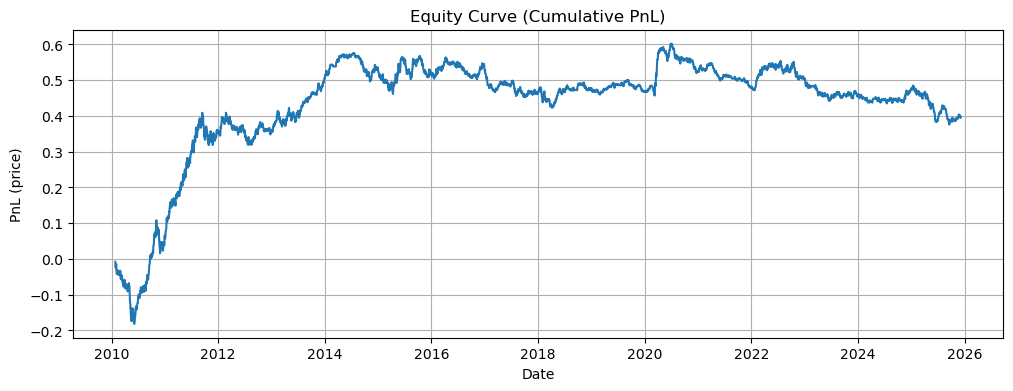

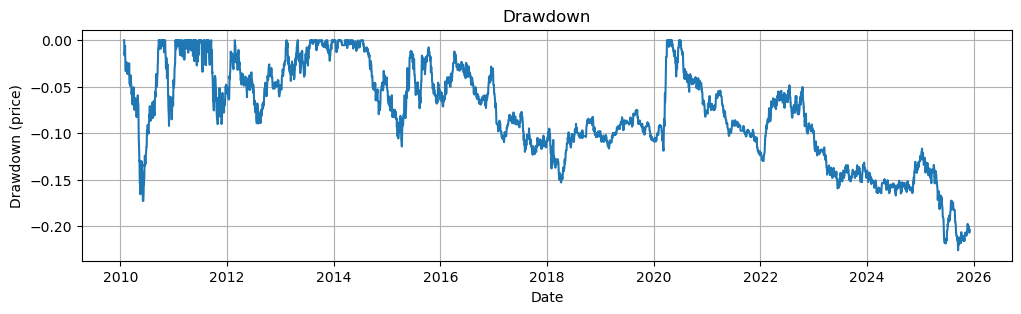

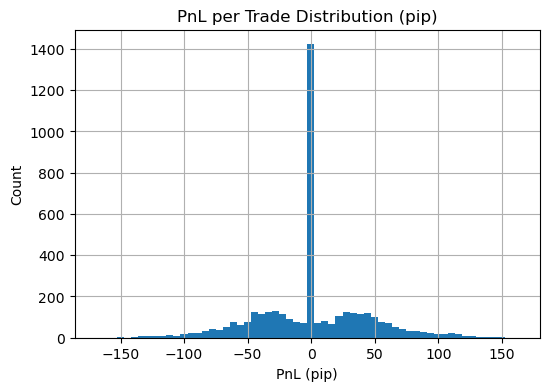

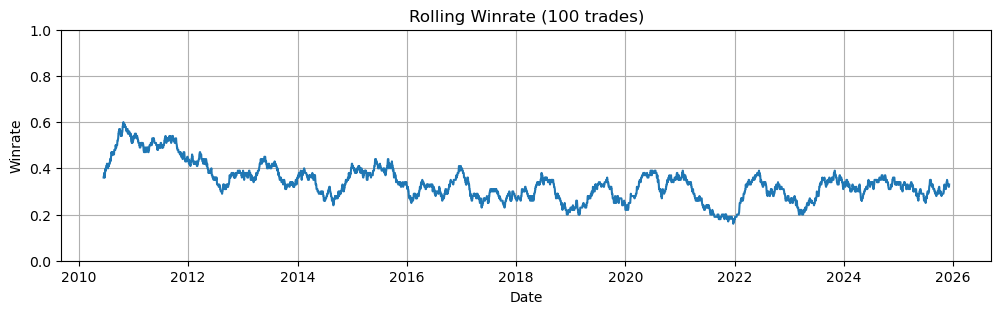

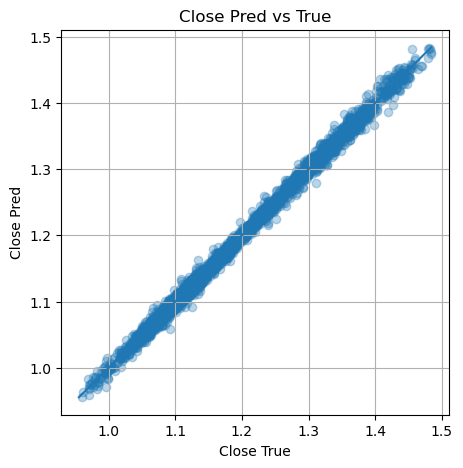

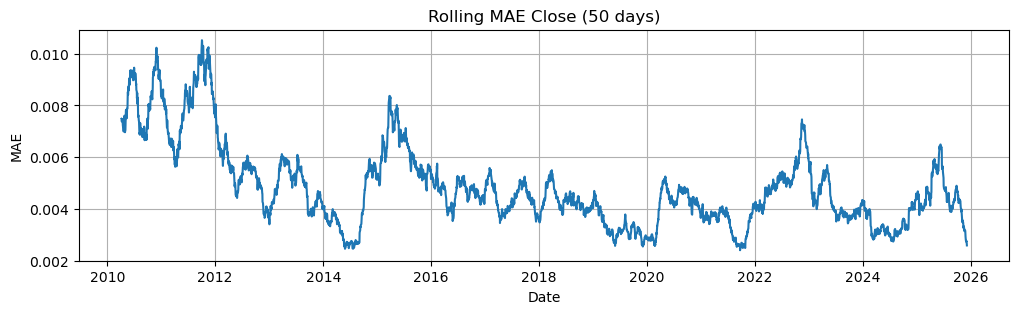

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ====== path ของไฟล์คุณ ======
csv_path = Path("/Users/thanaporn/Desktop/EURO_H1_AI/prepared_datasets/boosting_dl_residual/backtest_results.csv")

bt = pd.read_csv(csv_path, parse_dates=["date_t","date_next"])
bt = bt.sort_values("date_next").set_index("date_next")

# ถ้ายังไม่มี equity ให้สร้าง
if "equity" not in bt.columns:
    bt["equity"] = bt["pnl"].cumsum()

pip = 0.0001
bt["pnl_pip"] = bt["pnl"] / pip

# =========================
# 1) Equity curve
# =========================
plt.figure(figsize=(12,4))
plt.plot(bt.index, bt["equity"])
plt.title("Equity Curve (Cumulative PnL)")
plt.xlabel("Date")
plt.ylabel("PnL (price)")
plt.grid(True)
plt.show()

# =========================
# 2) Drawdown curve
# =========================
running_max = bt["equity"].cummax()
drawdown = bt["equity"] - running_max
bt["drawdown"] = drawdown

plt.figure(figsize=(12,3))
plt.plot(bt.index, bt["drawdown"])
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (price)")
plt.grid(True)
plt.show()

# =========================
# 3) Histogram ของ PnL ต่อเทรด
# =========================
plt.figure(figsize=(6,4))
plt.hist(bt["pnl_pip"], bins=60)
plt.title("PnL per Trade Distribution (pip)")
plt.xlabel("PnL (pip)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# =========================
# 4) Rolling winrate (เช่น 100 trades)
# =========================
win = (bt["pnl"] > 0).astype(int)
bt["roll_winrate_100"] = win.rolling(100).mean()

plt.figure(figsize=(12,3))
plt.plot(bt.index, bt["roll_winrate_100"])
plt.title("Rolling Winrate (100 trades)")
plt.xlabel("Date")
plt.ylabel("Winrate")
plt.ylim(0,1)
plt.grid(True)
plt.show()

# =========================
# 5) Pred vs True scatter (Close)
# =========================
plt.figure(figsize=(5,5))
plt.scatter(bt["Close_true"], bt["Close_pred"], alpha=0.3)
mn = min(bt["Close_true"].min(), bt["Close_pred"].min())
mx = max(bt["Close_true"].max(), bt["Close_pred"].max())
plt.plot([mn,mx],[mn,mx])  # เส้น y=x
plt.title("Close Pred vs True")
plt.xlabel("Close True")
plt.ylabel("Close Pred")
plt.grid(True)
plt.show()

# =========================
# 6) Error over time (MAE rolling 50)
# =========================
bt["close_abs_err"] = (bt["Close_true"] - bt["Close_pred"]).abs()
bt["roll_mae_close_50"] = bt["close_abs_err"].rolling(50).mean()

plt.figure(figsize=(12,3))
plt.plot(bt.index, bt["roll_mae_close_50"])
plt.title("Rolling MAE Close (50 days)")
plt.xlabel("Date")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


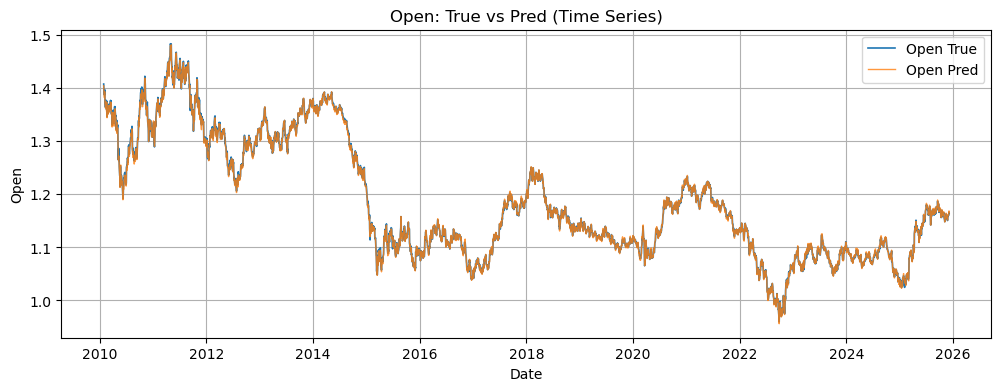

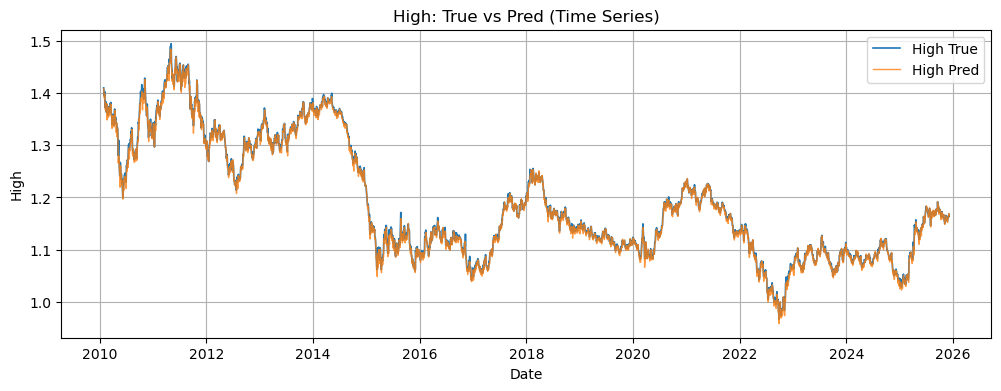

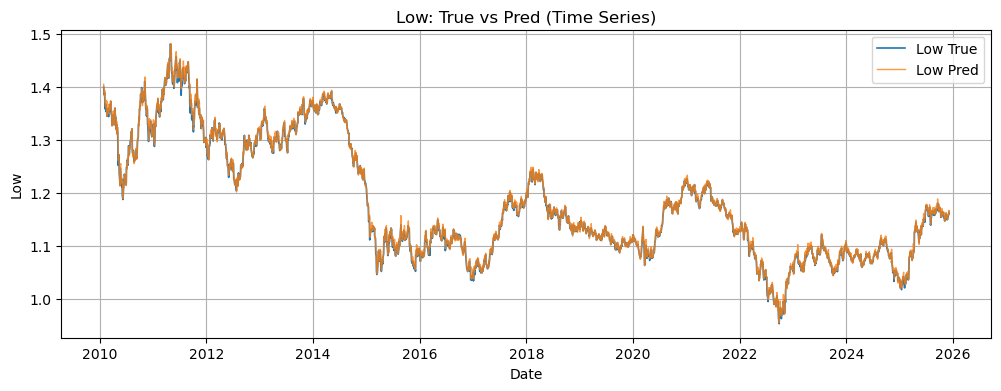

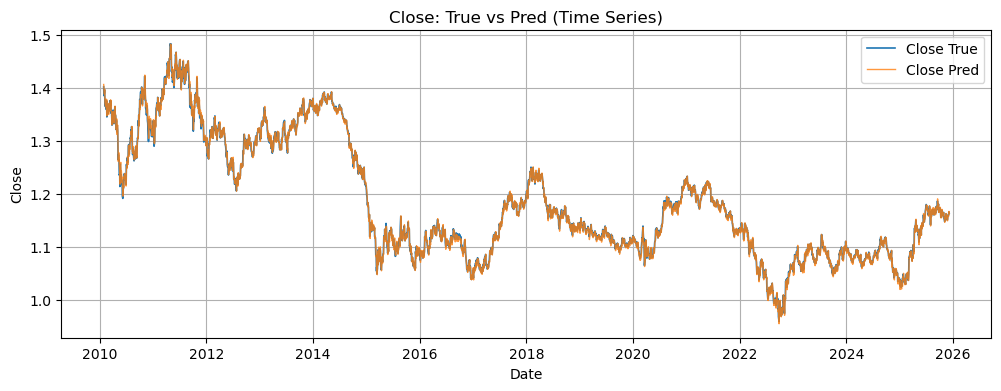

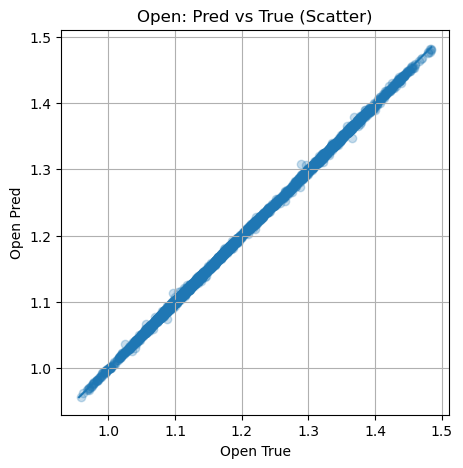

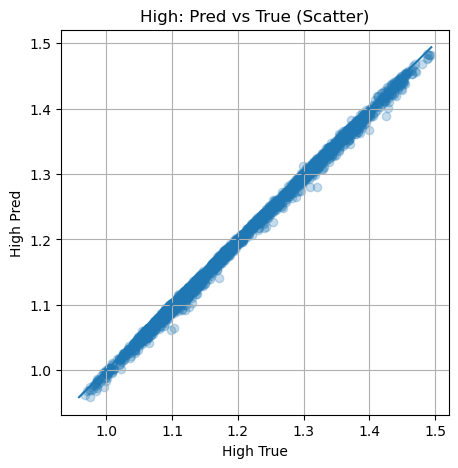

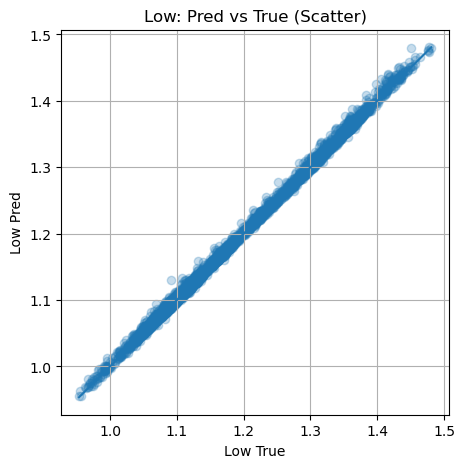

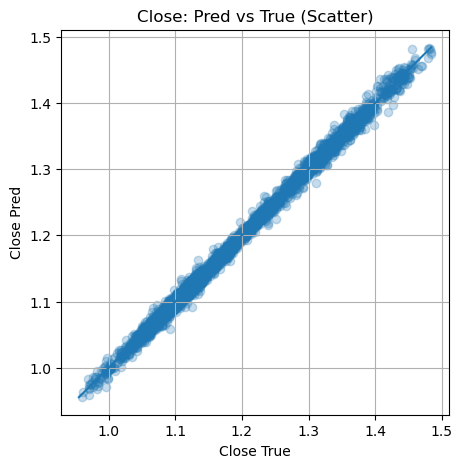

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ===== path ไฟล์ backtest ของคุณ =====
csv_path = Path("/Users/thanaporn/Desktop/EURO_H1_AI/prepared_datasets/boosting_dl_residual/backtest_results.csv")

bt = pd.read_csv(csv_path, parse_dates=["date_t","date_next"])
bt = bt.sort_values("date_next").set_index("date_next")

# =========================
# 1) กราฟเส้น: True vs Pred ตามเวลา
# =========================
cols = ["Open","High","Low","Close"]

for col in cols:
    plt.figure(figsize=(12,4))
    plt.plot(bt.index, bt[f"{col}_true"], label=f"{col} True", linewidth=1.2)
    plt.plot(bt.index, bt[f"{col}_pred"], label=f"{col} Pred", linewidth=1.0, alpha=0.8)
    plt.title(f"{col}: True vs Pred (Time Series)")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()

# =========================
# 2) Scatter: True vs Pred + เส้น y=x
# =========================
for col in cols:
    plt.figure(figsize=(5,5))
    plt.scatter(bt[f"{col}_true"], bt[f"{col}_pred"], alpha=0.25)
    mn = min(bt[f"{col}_true"].min(), bt[f"{col}_pred"].min())
    mx = max(bt[f"{col}_true"].max(), bt[f"{col}_pred"].max())
    plt.plot([mn,mx],[mn,mx])  # y=x
    plt.title(f"{col}: Pred vs True (Scatter)")
    plt.xlabel(f"{col} True")
    plt.ylabel(f"{col} Pred")
    plt.grid(True)
    plt.show()


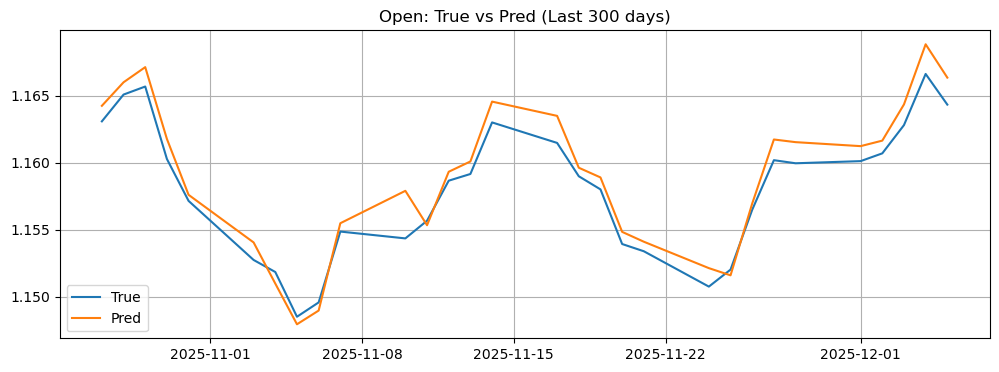

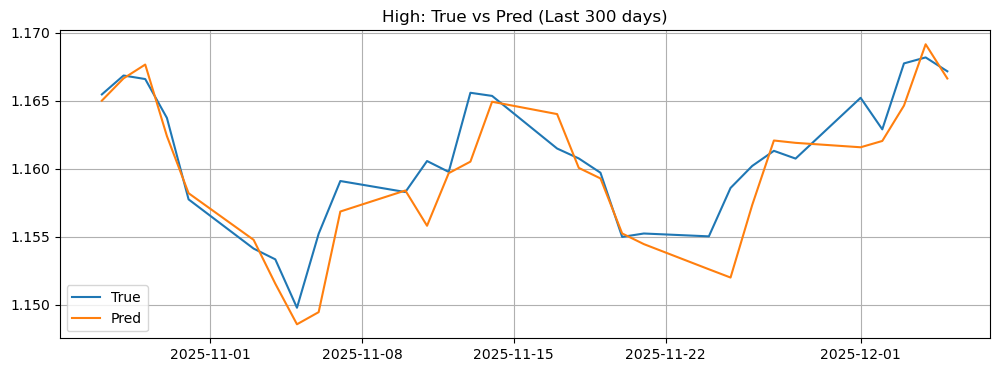

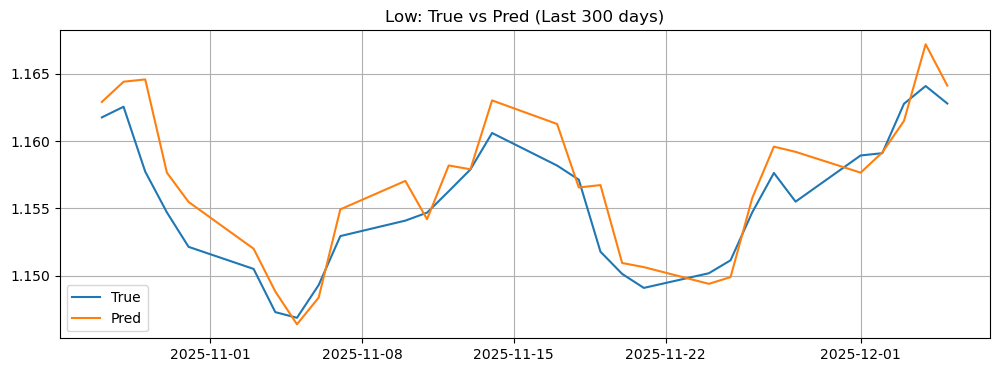

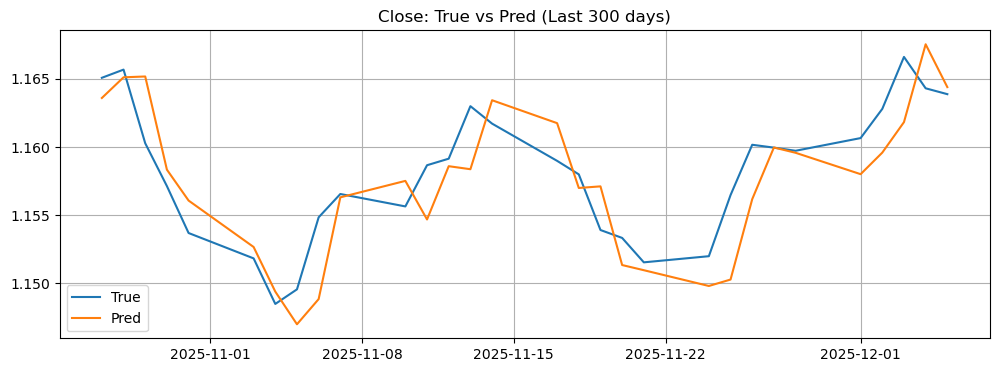

In [11]:
bt_tail = bt.tail(30)

for col in ["Open","High","Low","Close"]:
    plt.figure(figsize=(12,4))
    plt.plot(bt_tail.index, bt_tail[f"{col}_true"], label="True")
    plt.plot(bt_tail.index, bt_tail[f"{col}_pred"], label="Pred")
    plt.title(f"{col}: True vs Pred (Last 300 days)")
    plt.legend(); plt.grid(True); plt.show()
